# alternative data evaluation for multiple datasets 


In [1]:
# Definitions

import sys, os, warnings
import numpy as np
import pandas as pd
import plotly


for_html = False
if for_html == True:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

from aiq_strategy_robot.data.data_accessor import DAL
from asr_common.asr_calendar import shift_dt_index_to_specific_day
# warnings.simplefilter('ignore')

In [2]:
sdh = DAL()

## Loading data and pre-processing　 
In this section, all data are labeled with the earliest date that can be obtained.

### get the list of symbols

In [3]:
def load_symbols() -> pd.DataFrame:
    sdh = DAL()
    sdh = sdh.load(
        'ALTERNATIVE',
        data_type='aiq_pos_csmr_goods',
        meta_data='universe'
    )
    dfsyms = sdh.retrieve()
    dfsyms = dfsyms.rename({'TICKER': 'seccode'}, axis=1)
    list_figis = dfsyms['FIGI'].unique().tolist()

    sdh = sdh.load(
        'Factset',
        data_type='symbol_lookup',
        figi=list_figis,
        pick_only_primary=True
    )
    dfout = sdh.retrieve(pick_cols=['FIGI', 'TICKER', 'FSYM_ID', 'FSYM_SECURITY_ID']).sort_values('TICKER', ascending=True)
    dfout = dfout.drop_duplicates(keep='last')
    dfout = dfout.merge(dfsyms, on='FIGI', how='left')
    return dfout

In [4]:
dfsyms = load_symbols()
list_figis = dfsyms['FIGI'].unique().tolist()
list_tickers = dfsyms['TICKER'].unique().tolist()

### Load POS Data 
Note that we modify the datetime index from Sundays to Thursdays, because these data are only accessable by Thursday.

In [5]:
def load_pos_from_db(list_figis) -> pd.DataFrame:
    sdh = sdh.load(
        'ALTERNATIVE',
        data_type='aiq_pos_csmr_goods',
        meta_data='data',
        generation=2,
        figi=list_figis,
        load_only_raw=True,
        load_only_latest=True
    )
    df_pos = sdh.retrieve()
    df_pos = df_pos.merge(dfsyms2[['seccode', 'TICKER']], left_on='ticker', right_on='seccode', how='inner').drop(['seccode', 'ticker'], axis=1)
    df_pos = df_pos.rename(columns={'TICKER': 'ticker', 'DATETIME': 'datetime'})
    df_pos = df_pos.set_index(['ticker', 'datetime'])

    # shift pos datetime to the next friday.
    custom_mask = 'Mon Tue Wed Thu Fri'
    spec_day = 3
    new_dt_index = shift_dt_index_to_specific_day(pos_df0.index.get_level_values('datetime'), custom_mask, spec_day)
    pos_df0.index = pd.MultiIndex.from_arrays([pos_df0.index.get_level_values('ticker'), new_dt_index], names=['ticker', 'datetime'])
    return pos_df0

In [6]:
# Using existing data for reducing the amount of time for loading.
if True:
    pos_df0 = pd.read_parquet('/efs/share/factset/pattaya/sample/jupyter/aiq_pos_csmr_goods_sample_index_shift.parquet', engine='pyarrow')
else:
    pos_df0 = load_pos_from_db(list_figis)
    pos_df0.to_parquet('/efs/share/factset/pattaya/sample/jupyter/aiq_pos_csmr_goods_sample_index_shift.parquet', engine='pyarrow')

In [7]:
pos_df0.head()

pos_sales     share  unit_price  unit_price_vs_ind
ticker  datetime                                                      
1301-JP 2008-03-20   0.716136  0.036918    1.061700           0.794193
        2008-03-27   0.713317  0.036813    1.092624           0.825687
        2008-04-03   0.673215  0.033429    0.995762           0.745105
        2008-04-10   0.788698  0.036580    1.053193           0.781361
        2008-04-17   0.846764  0.039811    1.033405           0.777337

### Price Data (origin: FactSet HTTP API)

In [8]:
def load_market_prices(list_tickers, start_datetime) -> pd.DataFrame:
    dfmkt = sdh.load(
        'FACTSET',
        data_type='gpd_prices',
        ids=list_tickers,
        start_date=start_datetime,
        adjust='SPLIT',
        fields=['price', 'volume', 'priceOpen', 'priceHigh', 'priceLow', 'currency']
    ).retrieve()
    dfmkt = dfmkt.reset_index().rename(columns={'DATETIME': 'datetime'})
    dfmkt['datetime'] = pd.to_datetime(dfmkt['datetime'])
    dfmkt = dfmkt.set_index(['ticker', 'datetime'])[['close', 'volume', 'open', 'high', 'low', 'currency']]
    return dfmkt

In [9]:
# again we load the existing data for reducing the demo duration.
if True:
    prices_df = pd.read_parquet('/efs/share/factset/pattaya/sample/jupyter/aiq_pos_csmr_goods_mkt_long.parquet', engine='pyarrow')
else:
    prices_df = load_market_prices(list_tickers, '2016-01-01')
    prices_df.to_parquet('/efs/share/factset/pattaya/sample/jupyter/aiq_pos_csmr_goods_mkt_long.parquet', engine='pyarrow')

In [10]:
prices_df.head()

fsymId  TICKER_REGION   volume    open    high     low  \
ticker  datetime                                                               
1301-JP 2016-01-04  D0HPMH-R           1301  32000.0  2800.0  2820.0  2740.0   
        2016-01-05  D0HPMH-R           1301  20100.0  2750.0  2780.0  2750.0   
        2016-01-06  D0HPMH-R           1301  15000.0  2760.0  2770.0  2740.0   
        2016-01-07  D0HPMH-R           1301  31400.0  2740.0  2760.0  2710.0   
        2016-01-08  D0HPMH-R           1301  26200.0  2700.0  2740.0  2690.0   

                     close currency  
ticker  datetime                     
1301-JP 2016-01-04  2750.0      JPY  
        2016-01-05  2760.0      JPY  
        2016-01-06  2760.0      JPY  
        2016-01-07  2710.0      JPY  
        2016-01-08  2700.0      JPY

### TruValue data (origin: FactSet Snowflake)

In [11]:
def load_tv_for_tickers(list_tickers, tv_features):
    tv_tables = dict()
    for name in tqdm(['TV_ESG_RANKS', 'TV_INSIGHT', 'TV_MOMENTUM', 'TV_PULSE', 'TV_VOLUME', 'TV_VOLUME_PCTL']):
        tv_table = pd.read_csv(f'./data/POS266_{name}.csv')
        tv_table = tv_table.dropna(subset=['TV_DATE']).drop_duplicates()
        tv_table['datetime'] = pd.to_datetime(tv_table['TV_DATE'])
        tv_table['ticker'] = tv_table['ticker'].astype(str)
        tv_table = tv_table.set_index(['ticker', 'datetime']).sort_index()
        tv_table.drop(columns=['TV_DATE', 'TV_ORG_ID', 'TV_INSTRUMENT_ID'], inplace=True)
        # TV data are delivered on T+1 day
        tv_table = tv_table.groupby('ticker').shift(1)
        tv_tables[name] = tv_table

    merged_tv = None
    for (table, column) in tqdm(tv_features):
        if merged_tv is None:
            merged_tv = tv_tables[table][column].to_frame()
        else:
            merged_tv = merged_tv.merge(tv_tables[table][column].to_frame(), left_index=True, right_index=True, how='outer')
    merged_tv = merged_tv.groupby(level=['ticker', 'datetime']).mean()
    return merged_tv

In [12]:
if True:
    merged_tv = pd.read_parquet('/efs/share/factset/pattaya/sample/jupyter/aiq_pos_csmr_goods_tv.parquet', engine='pyarrow')
else:
    tv_features = [
        ('TV_ESG_RANKS', 'MATERIALITY_ADJ_INSIGHT'),
        ('TV_ESG_RANKS', 'MATERIALITY_IND_PCTL'),
        ('TV_ESG_RANKS', 'ALL_CATEGORIES_ADJ_INSIGHT'),
        ('TV_INSIGHT', 'ALL_CATEGORIES_INSIGHT'),
        ('TV_MOMENTUM', 'ALL_CATEGORIES_MOMENTUM'),
        ('TV_PULSE', 'ALL_CATEGORIES_PULSE'),
    ]
    merged_tv = load_tv_for_tickers(list_tickers, tv_features)
    merged_tv.to_parquet('/efs/share/factset/pattaya/sample/jupyter/aiq_pos_csmr_goods_tv.parquet', engine='pyarrow')

In [13]:
merged_tv.tail()

MATERIALITY_ADJ_INSIGHT  MATERIALITY_IND_PCTL  \
ticker  datetime                                                    
9997-JP 2023-11-16                    64.42                 40.63   
        2023-11-17                    64.41                 40.35   
        2023-11-18                    64.40                 40.28   
        2023-11-19                    64.35                 40.37   
        2023-11-20                    64.40                 40.23   

                    ALL_CATEGORIES_ADJ_INSIGHT  ALL_CATEGORIES_INSIGHT  \
ticker  datetime                                                         
9997-JP 2023-11-16                       76.55               76.545724   
        2023-11-17                       76.56               76.564881   
        2023-11-18                       76.58               76.583965   
        2023-11-19                       76.60               76.602976   
        2023-11-20                       76.62               76.621916   

                    ALL_CATEGORIES_MOMENTUM  ALL_CATEGORIES_PULSE  
ticker  datetime                                                   
9997-JP 2023-11-16                81.457731               81.5853  
        2023-11-17                81.409830               81.5853  
        2023-11-18                81.362007               81.5853  
        2023-11-19                81.314263               81.5853  
        2023-11-20                81.266596               81.5853

### Quants factors

In [14]:
if True:
    factors266 = pd.read_parquet('/efs/share/factset/pattaya/sample/jupyter/aiq_pos_csmr_goods_factors.parquet', engine='pyarrow') 
else:
    factors266 = load_quants_factors(list_tickers, '2016-01-01')

In [15]:
factors266.head()

mktVal  retMom252D        ey        roe        bp
ticker  datetime                                                        
1301-JP 2016-01-29  246.43140   -1.067609  3.670288  11.532198  0.784174
        2016-02-01  248.31880   -0.709224  3.642391  11.532198  0.778214
        2016-02-02  249.90881   -1.408452  3.619217  11.532198  0.773262
        2016-02-03  252.86449   -2.456135  3.576913  11.532198  0.764224
        2016-02-04  251.90051   -4.181176  3.590601  11.532198  0.767149

In [16]:
sdh.extract.clear()
data_id_price = sdh.set_raw_data(prices_df, data_source='FACTSET', source='gpd_prices')
data_id_f266 = sdh.set_raw_data(factors266, data_source='FACTSET', source='Quants factors')
data_id_pos = sdh.set_raw_data(pos_df0, data_source='ALTERNATIVE', source='aiq_pos_csmr_goods')
data_id_tv = sdh.set_raw_data(merged_tv, data_source='FACTSET', source='TrueValue')

In [17]:
sdh.set_alias({
    data_id_price: 'FTech',
    data_id_f266: 'FFactor',
    data_id_pos: 'FPos',
    data_id_tv: 'FTV',
})

In [18]:
sdh.extract_definition

category  data_source              source    table    alias exchanges  \
data_id                                                                         
1        RawData      FACTSET          gpd_prices  Unknown    FTech      None   
2        RawData      FACTSET      Quants factors  Unknown  FFactor      None   
3        RawData  ALTERNATIVE  aiq_pos_csmr_goods  Unknown     FPos      None   
4        RawData      FACTSET           TrueValue  Unknown      FTV      None   

                                                   tickers  \
data_id                                                      
1        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   
2        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   
3        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   
4        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   

                      index       start_datetime         end_datetime  
data_id                                                                
1        [ticker, datetime]  2016-01-04 00:00:00  2023-11-02 00:00:00  
2        [ticker, datetime]  2016-01-29 00:00:00  2023-10-31 00:00:00  
3        [ticker, datetime]  2008-03-20 00:00:00  2024-03-07 00:00:00  
4        [ticker, datetime]  2016-01-01 00:00:00  2023-11-20 00:00:00

### Resampling, featuring, and merging data sources

- Quants Factors: Daily
- TruValues: Daily
- POS Sales: Thursdays

In [19]:
resample_term = 'W-FRI'

In [20]:
sdh.transform.clear()
sdh.format.clear(data_id_price)
sdh.format.clear(data_id_f266)
sdh.format.clear(data_id_tv)
sdh.format.clear(data_id_pos)

aggregate_ohlcv = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}
format_id_price = sdh.format.start(data_id_price).resample(rule=resample_term, func=aggregate_ohlcv, label='left', closed='left').dropna(subset='close').finish()
format_id_f266 = sdh.format.start(data_id_f266).resample(rule=resample_term, func='last', label='left', closed='left').finish()
format_id_tv = sdh.format.start(data_id_tv).resample(rule=resample_term, func='last', label='left', closed='left').finish()
format_id_pos = sdh.format.start(data_id_pos).move_previous_business_day('Fri').resample(rule=resample_term, func='last', label='left', closed='left').finish()

### Technique Featuring 

In [21]:
# Baseline
baselines = []
X_shift = 2

In [22]:
# FTech
FTech_Ret001 = [('log_diff', dict(periods=1)), ('multiply_scalar', dict(value=100)), ('shift', dict(periods=X_shift))]    # 1週リターン
FTech_Ret004 = [('log_diff', dict(periods=4)), ('multiply_scalar', dict(value=100)), ('shift', dict(periods=X_shift))]    # 4週リターン
FTech_Volatility052 = [('log_diff', dict(periods=1)), ('volatility', dict(periods=52)), ('multiply_scalar', dict(value=100)), ('shift', dict(periods=X_shift))]   # 52週ボラティリティ

FTech_Ret001_id = sdh.transform.pipeline(data_id_price, format_id=format_id_price, fields=['close'], pipeline=FTech_Ret001)
FTech_Ret004_id = sdh.transform.pipeline(data_id_price, format_id=format_id_price, fields=['close'], pipeline=FTech_Ret004)
FTech_Volatility052_id = sdh.transform.pipeline(data_id_price, format_id=format_id_price, fields=['close'], pipeline=FTech_Volatility052)

In [23]:
baselines.extend(FTech_Ret001_id+FTech_Ret004_id+FTech_Volatility052_id)
baselines

[23, 26, 29]

In [24]:
# FFactor
FFactor_Marketcap_id, *_ = sdh.transform.pipeline(data_id_f266, format_id=format_id_f266, fields=['mktVal'], pipeline=[('log', dict()), ('shift', dict(periods=X_shift))])   # 時価総額はログ
FFactor_EY, FFactor_BP = sdh.transform.pipeline(data_id_f266, format_id=format_id_f266, fields=['ey', 'bp'], pipeline=[('shift', dict(periods=X_shift))]) 

In [25]:
baselines.extend([FFactor_Marketcap_id, FFactor_EY, FFactor_BP])
baselines

[23, 26, 29, 31, 32, 33]

In [26]:
# FTV
FTV_FIELDS = sdh.transform.pipeline(data_id_tv, format_id=format_id_tv, fields=merged_tv.columns, pipeline=[('shift', dict(periods=X_shift))]) 
FTV_MATERIALITY_ADJ_INSIGHT, FTV_MATERIALITY_IND_PCTL, \
                  FTV_ALL_CATEGORIES_ADJ_INSIGHT, FTV_ALL_CATEGORIES_INSIGHT, FTV_ALL_CATEGORIES_MOMENTUM, FTV_ALL_CATEGORIES_PULSE = FTV_FIELDS
baselines.extend(FTV_FIELDS)
baselines

[23, 26, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39]

In [27]:
# FPos
FPos_pipeline = [('sma', dict(periods=12)), ('diff', dict(periods=52)), ('shift', dict(periods=X_shift))]   # 12週移動平均の52週Diff
FPos_sales, FPos_share = sdh.transform.pipeline(data_id_pos, format_id=format_id_pos, fields=['pos_sales', 'share'], pipeline=FPos_pipeline)

baselines.extend([FPos_sales, FPos_share])
baselines

[23, 26, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 45]

In [28]:
# Make return
return_pipeline = [('log_diff', dict(periods=1)), ('multiply_scalar', dict(value=100))]
open_return, *_ = sdh.transform.pipeline(data_id_price, format_id=format_id_price, fields=['open'], pipeline=return_pipeline)

In [29]:
# sdh.get_transformed_data(variables=[open_return]).tail()

In [30]:
# Shift 2 to Baselines
# baselines = [sdh.transform.shift(field=b, periods=2).last_definition.variable_id for b in baselines]

## Baseline

In [31]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

In [32]:
start_date = '2018-02-25'
end_date = '2023-10-27'

Variables being created: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


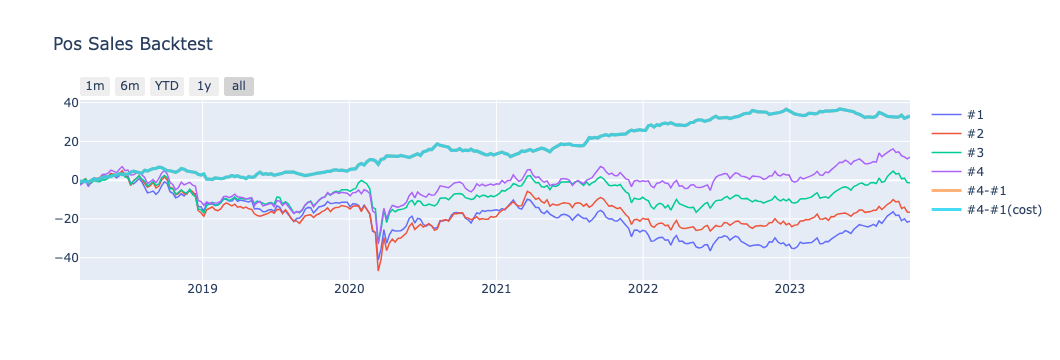

cum.Ret   ann.Ret    ann.Std       R/R     Win_R  ann.TurnOver  \
#1          -21.237549 -3.753852  14.805589 -0.253543  0.520270      3.323051   
#2          -16.513333 -2.918822  15.642715 -0.186593  0.557432      6.124340   
#3           -1.287699 -0.227608  14.997441 -0.015176  0.543919      6.166728   
#4           11.866816  2.097524  15.025640  0.139596  0.547297      2.898221   
#4-#1        33.104365  5.851377   5.078135  1.152269  0.550676      6.221272   
#4-#1(cost)  33.097325  5.850133   5.078125  1.152026  0.550676      6.221272   

                Max_DD  Calmar Ratio  
#1          -45.328900     -0.082814  
#2          -51.734235     -0.056420  
#3          -35.756987     -0.006365  
#4          -40.014148      0.052420  
#4-#1        -6.554653      0.892706  
#4-#1(cost)  -6.555264      0.892433

In [33]:
dfqret, dfsigqt = ade.q_backtest(
    FPos_sales,
    open_return,
    nq=4,
    fromd=start_date,
    tod=end_date,
    shift_signal=0,
    qmax=None,
    qmin=None,
    plot='Pos Sales Backtest'
)

Variables being created: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


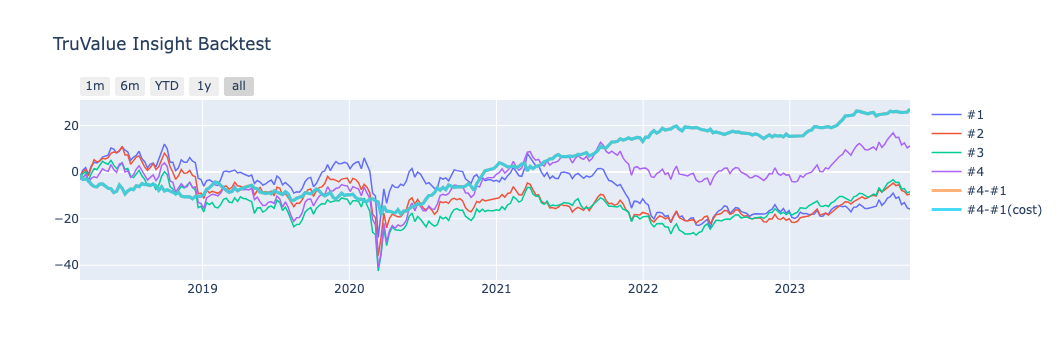

cum.Ret   ann.Ret    ann.Std       R/R     Win_R  ann.TurnOver  \
#1          -15.887676 -2.808233  17.439277 -0.161029  0.510135      2.686283   
#2           -9.393714 -1.660390  15.609688 -0.106369  0.533784      6.695950   
#3           -8.373479 -1.480058  15.950270 -0.092792  0.516892      6.123535   
#4           11.221629  1.983484  17.756063  0.111707  0.543919      1.770595   
#4-#1        27.109306  4.791717   7.439300  0.644109  0.557432      4.456878   
#4-#1(cost)  27.104263  4.790826   7.439323  0.643987  0.557432      4.456878   

                Max_DD  Calmar Ratio  
#1          -40.115624     -0.070003  
#2          -46.888220     -0.035412  
#3          -47.515517     -0.031149  
#4          -44.805311      0.044269  
#4-#1       -17.114086      0.279987  
#4-#1(cost) -17.116097      0.279902

In [34]:
dfqret, dfsigqt = ade.q_backtest(
    FTV_MATERIALITY_ADJ_INSIGHT,
    open_return,
    nq=4,
    fromd=start_date,
    tod=end_date,
    shift_signal=0,
    qmax=None,
    qmin=None,
    plot='TruValue Insight Backtest'
)

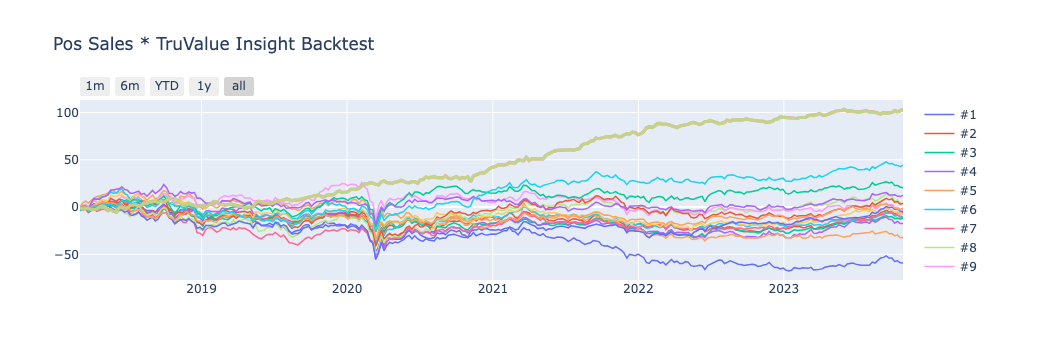

cum.Ret    ann.Ret    ann.Std       R/R     Win_R  \
#1            -59.280516 -10.478154  17.769346 -0.589676  0.466216   
#2             -6.067183  -1.072408  16.267600 -0.065923  0.533784   
#3            -11.898913  -2.103198  16.493239 -0.127519  0.493243   
#4            -17.541475  -3.100551  18.959519 -0.163535  0.516892   
#5            -32.085794  -5.671339  20.179102 -0.281050  0.523649   
#6            -10.258745  -1.813289  17.692245 -0.102491  0.527027   
#7            -11.153381  -1.971421  18.431726 -0.106958  0.513514   
#8              3.905152   0.690257  20.507859  0.033658  0.550676   
#9             -2.988993  -0.528321  19.392647 -0.027243  0.530405   
#10            -7.304739  -1.291152  17.417110 -0.074131  0.527027   
#11            -4.673294  -0.826030  17.659024 -0.046777  0.530405   
#12             3.851285   0.680736  19.085381  0.035668  0.537162   
#13            20.249750   3.579254  18.211774  0.196535  0.554054   
#14            12.353989   2.183635  16.087125  0.135738  0.547297   
#15            -1.017463  -0.179842  15.759775 -0.011411  0.506757   
#16            44.382681   7.844881  17.098356  0.458809  0.537162   
#16-#1        103.663196  18.323035  10.411568  1.759873  0.604730   
#16-#1(cost)  103.648889  18.320506  10.411578  1.759628  0.604730   

              ann.TurnOver     Max_DD  Calmar Ratio  
#1                6.586118 -75.261844     -0.139223  
#2               11.519354 -43.165220     -0.024844  
#3               11.558824 -42.180276     -0.049862  
#4                6.858277 -50.732928     -0.061115  
#5               10.094509 -53.364298     -0.106276  
#6               17.131811 -58.529820     -0.030981  
#7               16.780953 -56.615352     -0.034821  
#8               11.926216 -50.396993      0.013696  
#9               12.311042 -39.789599     -0.013278  
#10              18.257601 -48.391360     -0.026681  
#11              16.120518 -58.427524     -0.014138  
#12              11.325382 -50.695433      0.013428  
#13               8.494808 -32.279179      0.110884  
#14              12.284504 -43.009634      0.050771  
#15              11.528829 -40.069096     -0.004488  
#16               6.058798 -34.246604      0.229070  
#16-#1           12.644916 -10.266372      1.784762  
#16-#1(cost)     12.644916 -10.268332      1.784175

In [35]:
dfqret, dfsigqt = ade.q_backtest(
    [FPos_sales, FTV_MATERIALITY_ADJ_INSIGHT],
    open_return,
    nq=[4, 4],
    fromd=start_date,
    tod=end_date,
    shift_signal=0,
    qmax=None,
    qmin=None,
    plot='Pos Sales * TruValue Insight Backtest'
)

> qmax, qminの指定<br>
> 最良の成績の分位と最低の成績の分位をそれぞれ抽出

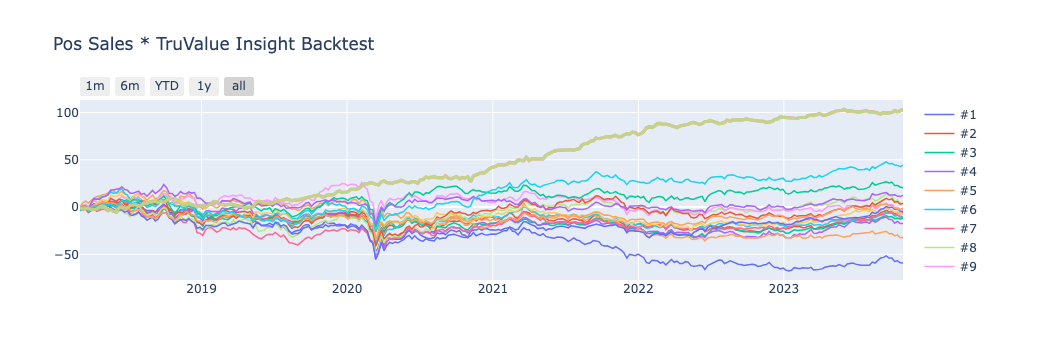

cum.Ret    ann.Ret    ann.Std       R/R     Win_R  \
#1            -59.280516 -10.478154  17.769346 -0.589676  0.466216   
#2             -6.067183  -1.072408  16.267600 -0.065923  0.533784   
#3            -11.898913  -2.103198  16.493239 -0.127519  0.493243   
#4            -17.541475  -3.100551  18.959519 -0.163535  0.516892   
#5            -32.085794  -5.671339  20.179102 -0.281050  0.523649   
#6            -10.258745  -1.813289  17.692245 -0.102491  0.527027   
#7            -11.153381  -1.971421  18.431726 -0.106958  0.513514   
#8              3.905152   0.690257  20.507859  0.033658  0.550676   
#9             -2.988993  -0.528321  19.392647 -0.027243  0.530405   
#10            -7.304739  -1.291152  17.417110 -0.074131  0.527027   
#11            -4.673294  -0.826030  17.659024 -0.046777  0.530405   
#12             3.851285   0.680736  19.085381  0.035668  0.537162   
#13            20.249750   3.579254  18.211774  0.196535  0.554054   
#14            12.353989   2.183635  16.087125  0.135738  0.547297   
#15            -1.017463  -0.179842  15.759775 -0.011411  0.506757   
#16            44.382681   7.844881  17.098356  0.458809  0.537162   
#16-#1        103.663196  18.323035  10.411568  1.759873  0.604730   
#16-#1(cost)  103.648889  18.320506  10.411578  1.759628  0.604730   

              ann.TurnOver     Max_DD  Calmar Ratio  
#1                6.586118 -75.261844     -0.139223  
#2               11.519354 -43.165220     -0.024844  
#3               11.558824 -42.180276     -0.049862  
#4                6.858277 -50.732928     -0.061115  
#5               10.094509 -53.364298     -0.106276  
#6               17.131811 -58.529820     -0.030981  
#7               16.780953 -56.615352     -0.034821  
#8               11.926216 -50.396993      0.013696  
#9               12.311042 -39.789599     -0.013278  
#10              18.257601 -48.391360     -0.026681  
#11              16.120518 -58.427524     -0.014138  
#12              11.325382 -50.695433      0.013428  
#13               8.494808 -32.279179      0.110884  
#14              12.284504 -43.009634      0.050771  
#15              11.528829 -40.069096     -0.004488  
#16               6.058798 -34.246604      0.229070  
#16-#1           12.644916 -10.266372      1.784762  
#16-#1(cost)     12.644916 -10.268332      1.784175

In [36]:
dfqret, dfsigqt = ade.q_backtest(
    [FPos_sales, FTV_MATERIALITY_ADJ_INSIGHT],
    open_return,
    nq=[4, 4],
    fromd=start_date,
    tod=end_date,
    shift_signal=0,
    qmax='max',
    qmin='min',
    plot='Pos Sales * TruValue Insight Backtest'
)

## Machine Learning


### Prediction by Baseline

In [37]:
from aiq_strategy_robot.predictors import ScikitLearnPredictor

slp = ScikitLearnPredictor(sdh)

In [38]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.0001)

### Specifying train/test period

#### Model fitting and prediction with growing_window.

In [39]:
verbose=False

In [40]:
dfpred, dfstats = slp.predict_with_growing_window(
    features=baselines,
    objective=open_return,
    model=model, 
    test_from=['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01'],
    max_train_duration=pd.DateOffset(months=24),    # Specification of the maximum period to be used for the study. If not specified, the entire period is used.
    dropna=True,                                    # Missing values cause errors when fitting, so exclude missing values in pre-processing.
    update_name='growing_window',                   # Specifies the name of the prediction result and registers it in the handler with that name. If not specified, it is not registered.
    verbose=verbose
)

Prediction running on a rolling period basis.: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


### Model fitting and prediction with sliding_window.


In [41]:
dfpred, dfstats = slp.predict_with_sliding_window(
    features=baselines,
    objective=open_return,
    model=model,
    test_start='2021-02-26', 
    test_end='2023-10-27', 
    test_period=4*3,
    train_period=52*3,
    period_freq='W-FRI',
    min_train_sample=50,
    dropna=True,
    update_name='sliding_wingow',
    verbose=verbose
)

Prediction running on a rolling period basis.: 100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.20it/s]


rho      RMSE       MAE
Stats.  0.048336  3.316623  2.351579

#### Specifying pre-processing parameters

In [42]:
dfpred, dfstats = slp.predict_with_sliding_window(
    features=baselines,
    objective=open_return,
    model=model,
    test_start='2021-02-25', 
    test_end='2023-10-27', 
    test_period=4*3,
    train_period=52*3,
    period_freq= 'W-FRI',
    min_train_sample=50,
    
    # Main pre-treatment parameters.
    clip_q = 0.01,                # Quantile used for clipping features.
    q_cut_Y=False,                # Specifies whether to apply clipping to the objective (Y) as defined by `clip_q`
    normal_scaling='datetime',    # Type of normalization applied to features.
    normal_scaling_Y=False,       # Specifies whether to apply normalization to the objective (Y) as defined by `normal_scaling`
    impute_x=None,                # Specifies the method for imputing missing values in features. Ffill, KNN and Iterative can be specified.
    dropna=True,                  # If True, rows containing missing values will be dropped. Default is False.
    update_name='sliding_wingow with pre-processing',
    verbose=verbose
)

Prediction running on a rolling period basis.: 100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.98it/s]


rho      RMSE       MAE
Stats.  0.041247  3.314091  2.341447

In [43]:
sdh.extract.definition

category                         data_source              source  \
data_id                                                                       
1           RawData                             FACTSET          gpd_prices   
2           RawData                             FACTSET      Quants factors   
3           RawData                         ALTERNATIVE  aiq_pos_csmr_goods   
4           RawData                             FACTSET           TrueValue   
5        Prediction                      growing_window             Unknown   
6        Prediction                      sliding_wingow             Unknown   
7        Prediction  sliding_wingow with pre-processing             Unknown   

           table     alias exchanges  \
data_id                                
1        Unknown     FTech      None   
2        Unknown   FFactor      None   
3        Unknown      FPos      None   
4        Unknown       FTV      None   
5        Unknown   Unknown      None   
6        Unknown  Unknown6      None   
7        Unknown  Unknown7      None   

                                                   tickers  \
data_id                                                      
1        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   
2        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   
3        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   
4        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   
5        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 2001-JP, ...   
6        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 2001-JP, ...   
7        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 2001-JP, ...   

                      index       start_datetime         end_datetime  
data_id                                                                
1        [ticker, datetime]  2016-01-04 00:00:00  2023-11-02 00:00:00  
2        [ticker, datetime]  2016-01-29 00:00:00  2023-10-31 00:00:00  
3        [ticker, datetime]  2008-03-20 00:00:00  2024-03-07 00:00:00  
4        [ticker, datetime]  2016-01-01 00:00:00  2023-11-20 00:00:00  
5        [ticker, datetime]  2020-01-03 00:00:00  2023-10-27 00:00:00  
6        [ticker, datetime]  2021-02-26 00:00:00  2023-10-27 00:00:00  
7        [ticker, datetime]  2021-02-26 00:00:00  2023-10-27 00:00:00

## Backtesting by Prediction

In [44]:
start_date = '2018-02-25'
end_date = '2023-10-27'

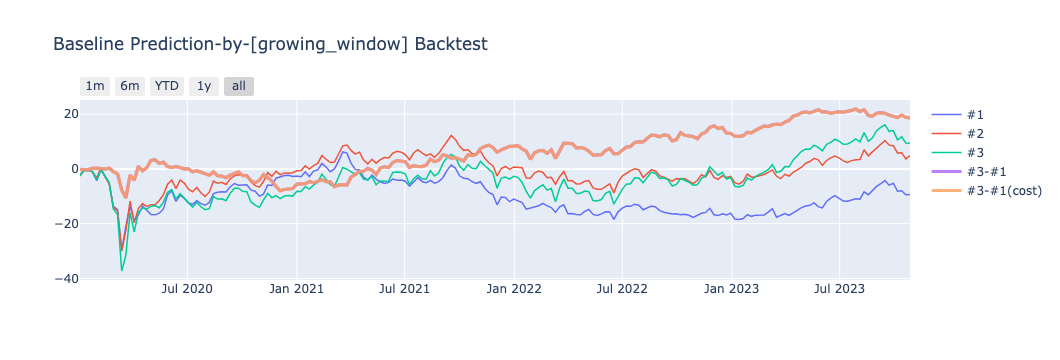

cum.Ret   ann.Ret    ann.Std       R/R  Win_R  ann.TurnOver  \
#1           -9.324332 -2.443202  15.348921 -0.159177  0.495     17.093852   
#2            4.847358  1.270126  16.925596  0.075042  0.525     26.597793   
#3            9.338098  2.446810  20.701993  0.118192  0.525     17.465217   
#3-#1        18.662430  4.890012   9.814451  0.498246  0.525     34.559069   
#3-#1(cost)  18.636051  4.883100   9.814407  0.497544  0.525     34.559069   

                Max_DD  Calmar Ratio  
#1          -29.348898     -0.083247  
#2          -30.395427      0.041787  
#3          -37.099796      0.065952  
#3-#1       -11.346220      0.430982  
#3-#1(cost) -11.348805      0.430274

In [45]:
dfqret, dfsigqt = ade.q_backtest(
    'growing_window',
    open_return,
    nq=3,
    fromd=start_date,
    tod=end_date,
    shift_signal=0,
    qmax=None,
    qmin=None,
    swap_long_short=False,
    plot='Baseline Prediction-by-[growing_window] Backtest'
)

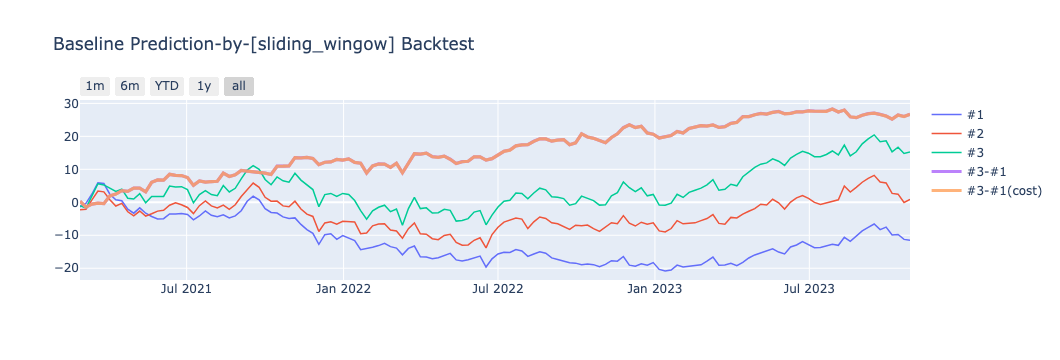

cum.Ret    ann.Ret    ann.Std       R/R     Win_R  \
#1          -11.492259  -4.311074   9.746845 -0.442305  0.507143   
#2            0.910551   0.341573  11.794562  0.028960  0.521429   
#3           15.225576   5.711547  14.237344  0.401167  0.550000   
#3-#1        26.717835  10.022621   7.759106  1.291724  0.585714   
#3-#1(cost)  26.698168  10.015243   7.759093  1.290775  0.585714   

             ann.TurnOver     Max_DD  Calmar Ratio  
#1              18.094314 -26.735898     -0.161247  
#2              27.792359 -19.630834      0.017400  
#3              18.793897 -18.044163      0.316532  
#3-#1           36.888211  -4.736391      2.116088  
#3-#1(cost)     36.888211  -4.737582      2.113999

In [46]:
dfqret, dfsigqt = ade.q_backtest(
    'sliding_wingow',
    open_return,
    nq=3,
    fromd=start_date,
    tod=end_date,
    shift_signal=0,
    qmax=None,
    qmin=None,
    swap_long_short=False,
    plot='Baseline Prediction-by-[sliding_wingow] Backtest'
)

Variables being created: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.82it/s]


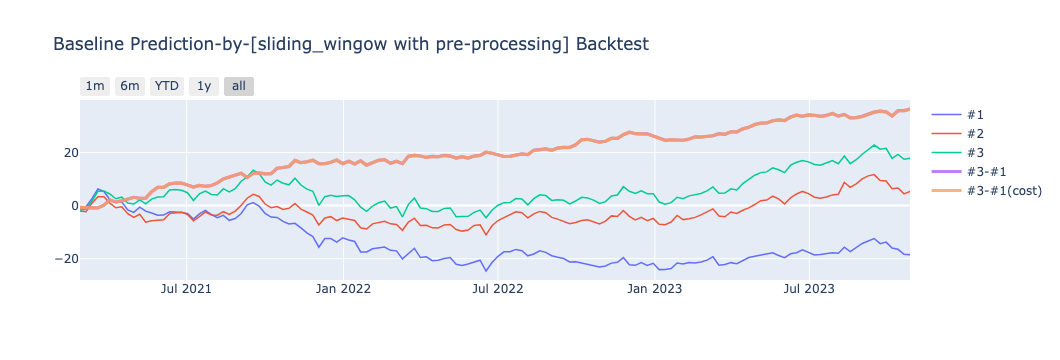

cum.Ret    ann.Ret    ann.Std       R/R     Win_R  \
#1          -18.514035  -6.945142  11.033016 -0.629487  0.500000   
#2            5.343039   2.004326  11.510248  0.174134  0.550000   
#3           17.867763   6.702706  12.945669  0.517757  0.578571   
#3-#1        36.381797  13.647848   6.019882  2.267129  0.635714   
#3-#1(cost)  36.362208  13.640500   6.019887  2.265906  0.635714   

             ann.TurnOver     Max_DD  Calmar Ratio  
#1              17.750518 -30.870268     -0.224978  
#2              27.856282 -15.251049      0.131422  
#3              18.991424 -17.869600      0.375090  
#3-#1           36.741941  -3.058204      4.462700  
#3-#1(cost)     36.741941  -3.059070      4.459035

In [47]:
dfqret, dfsigqt = ade.q_backtest(
    'sliding_wingow with pre-processing',
    open_return,
    nq=3,
    fromd=start_date,
    tod=end_date,
    shift_signal=0,
    qmax=None,
    qmin=None,
    swap_long_short=False,
    plot='Baseline Prediction-by-[sliding_wingow with pre-processing] Backtest'
)

### Prediction VS AltData

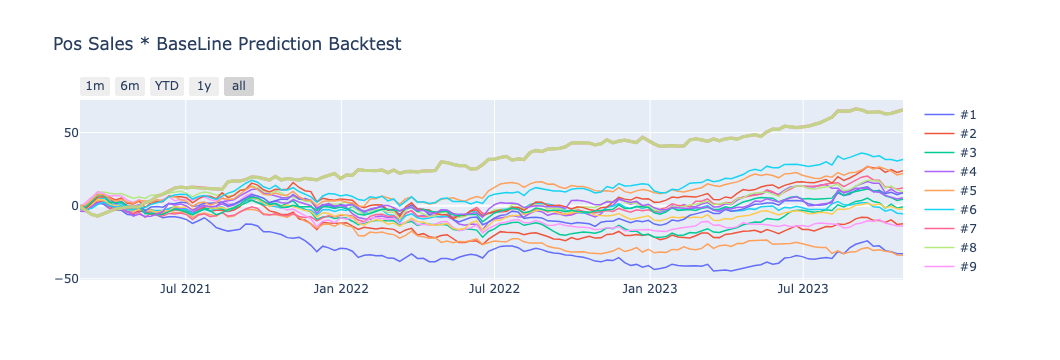

cum.Ret    ann.Ret    ann.Std       R/R     Win_R  \
#1           -32.911822 -12.346161  13.235367 -0.932816  0.435714   
#2           -12.308743  -4.617360  13.129432 -0.351680  0.471429   
#3            -0.734235  -0.275433  12.480225 -0.022070  0.514286   
#4             8.549716   3.207242  14.739424  0.217596  0.500000   
#5           -33.970142 -12.743167  12.913795 -0.986787  0.428571   
#6            -5.538949  -2.077817  12.225655 -0.169956  0.535714   
#7            12.104428   4.540716  13.588383  0.334162  0.535714   
#8             9.737977   3.652992  14.968396  0.244047  0.557143   
#9           -13.806329  -5.179147  13.328275 -0.388583  0.521429   
#10           -2.402336  -0.901185  12.727402 -0.070807  0.492857   
#11            8.831143   3.312813  14.943839  0.221684  0.535714   
#12           23.929860   8.976772  16.197137  0.554220  0.528571   
#13            4.362469   1.636486  12.711741  0.128738  0.542857   
#14            5.497921   2.062427  13.955244  0.147789  0.500000   
#15           22.018947   8.259934  13.222374  0.624694  0.507143   
#16           31.532374  11.828691  13.935293  0.848830  0.535714   
#16-#5        65.502517  24.571859  11.890981  2.066428  0.592857   
#16-#5(cost)  65.475863  24.561860  11.890988  2.065586  0.592857   

              ann.TurnOver     Max_DD  Calmar Ratio  
#1               21.878610 -46.590352     -0.264994  
#2               34.041203 -30.345161     -0.152161  
#3               34.579740 -25.328640     -0.010874  
#4               27.015028 -23.148006      0.138554  
#5               27.357665 -41.804015     -0.304831  
#6               35.823767 -16.502940     -0.125906  
#7               35.916372 -15.333823      0.296124  
#8               28.680087 -22.433099      0.162839  
#9               24.673886 -28.257789     -0.183282  
#10              35.992061 -22.264929     -0.040476  
#11              36.144494 -21.796205      0.151990  
#12              27.056804 -24.646240      0.364225  
#13              25.651114 -17.974180      0.091047  
#14              35.199934 -19.255947      0.107106  
#15              33.976219 -13.657848      0.604776  
#16              22.634267 -17.458698      0.677524  
#16-#5           49.991931  -6.412170      3.832066  
#16-#5(cost)     49.991931  -6.412745      3.830163

In [48]:
dfqret, dfsigqt = ade.q_backtest(
    [FPos_sales, 'sliding_wingow with pre-processing'],
    open_return,
    nq=[4, 4],
    fromd=start_date,
    tod=end_date,
    shift_signal=0,
    qmax='max',
    qmin='min',
    plot='Pos Sales * BaseLine Prediction Backtest'
)

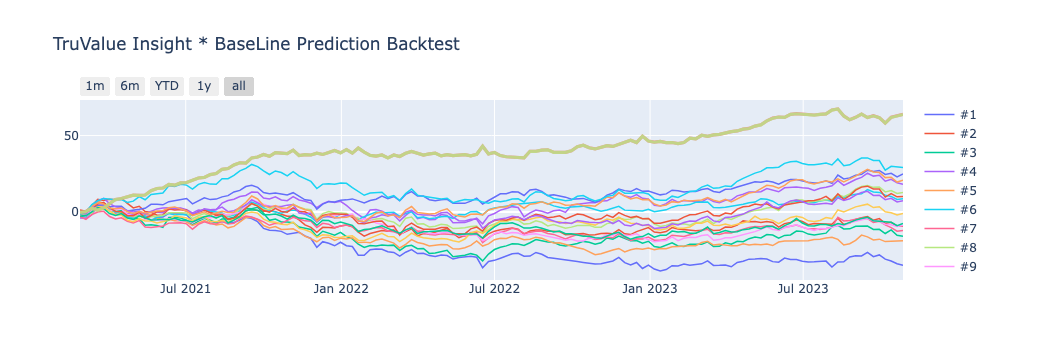

cum.Ret    ann.Ret    ann.Std       R/R     Win_R  \
#1           -34.802902 -13.055559  14.251794 -0.916064  0.457143   
#2            -9.372623  -3.515938  13.363514 -0.263100  0.521429   
#3           -15.912682  -5.969300  14.532642 -0.410751  0.500000   
#4            18.201115   6.827756  15.550087  0.439082  0.542857   
#5           -18.845459  -7.069468  11.641859 -0.607246  0.542857   
#6             8.749670   3.282250  10.971488  0.299162  0.571429   
#7           -12.023468  -4.510345  13.018879 -0.346446  0.485714   
#8            12.793188   4.799089  13.581406  0.353357  0.571429   
#9            -8.763347  -3.287381  12.399330 -0.265126  0.507143   
#10           -1.006750  -0.377661  12.588023 -0.030002  0.478571   
#11           24.871712   9.330087  12.572865  0.742081  0.585714   
#12           10.182093   3.819593  15.397102  0.248072  0.557143   
#13           -7.458476  -2.797887  12.585629 -0.222308  0.521429   
#14            7.440691   2.791215  13.889360  0.200961  0.535714   
#15           20.769068   7.791069  14.014855  0.555915  0.564286   
#16           29.039488  10.893539  14.885763  0.731809  0.564286   
#16-#1        63.842390  23.949098  12.125754  1.975061  0.628571   
#16-#1(cost)  63.816230  23.939284  12.125763  1.974250  0.628571   

              ann.TurnOver     Max_DD  Calmar Ratio  
#1               23.213442 -44.750602     -0.291740  
#2               34.669638 -26.380594     -0.133277  
#3               35.318630 -35.779163     -0.166837  
#4               24.952769 -20.778999      0.328589  
#5               27.079728 -35.018158     -0.201880  
#6               34.694227 -13.066951      0.251187  
#7               35.113256 -20.534268     -0.219650  
#8               26.586378 -18.870384      0.254319  
#9               27.185352 -27.683366     -0.118749  
#10              35.290211 -23.525092     -0.016054  
#11              35.301280 -15.631126      0.596892  
#12              25.449530 -21.338970      0.178996  
#13              25.155964 -20.755309     -0.134803  
#14              34.716814 -19.741147      0.141391  
#15              36.233337 -16.768829      0.464616  
#16              25.854593 -25.431472      0.428349  
#16-#1           49.068035  -9.175824      2.610021  
#16-#1(cost)     49.068035  -9.176843      2.608662

In [49]:
dfqret, dfsigqt = ade.q_backtest(
    [FTV_MATERIALITY_ADJ_INSIGHT, 'sliding_wingow with pre-processing'],
    open_return,
    nq=[4, 4],
    fromd=start_date,
    tod=end_date,
    shift_signal=0,
    qmax='max',
    qmin='min',
    plot='TruValue Insight * BaseLine Prediction Backtest'
)